In [1]:
from functions import *

In [3]:
# Define parameters 
num_monomers = 20 
mean_bond_length = 1
std_bond_length = 20
gaussian_noise_std = 10

num_observation_list = [30, 70]
num_templates = 2

template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]
observation_list = [generate_observations(c, n, gaussian_noise_std) for c, n in zip(template_chain_list, num_observation_list)]

observation_list = np.concatenate([*observation_list])


In [4]:
observation_class_list = np.concatenate([[i for _ in range(j)] for i, j in enumerate(num_observation_list)])

In [5]:
observation_class_list 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [6]:
observations_flatten = jnp.array([generate_flatten_distance_map(t) for t in observation_list])

INFO:jax._src.lib.xla_bridge:Remote TPU is not linked into jax; skipping remote TPU.
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Host Interpreter
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


In [7]:
def generate_posterior_parallelize(templates_flatten, observations_flatten, template_weights, weight_renormalization=1000):
    """
    """ 
    templates_flatten = jnp.array(templates_flatten)
    observations_flatten = jnp.array(observations_flatten)
    
    template_weights = jnp.array(template_weights)
    
    weight_prior = 1/len(template_weights) 
    
    # Generate grid index combination
    template_info_indices = jnp.arange(len(templates_flatten))
    observation_info_indices = jnp.arange(len(observations_flatten))
    t_ind, o_ind = jnp.meshgrid(template_info_indices, observation_info_indices)
    
    total_posterior = 0
    
    t_ind = t_ind.flatten()
    o_ind = o_ind.flatten()
    
    # jax.debug.print("Weights at current iteration: {y}", y=template_weights)
    def calculate_rhs(t_ind, o_ind):
        val = 0 
        o = observations_flatten[o_ind]
        t = templates_flatten[t_ind]
        alpha = template_weights[t_ind]
        
        val += loglikelihood(o, t, measurement_error, num_probes)

        val += logprior(t, num_probes)

        # This is the correct one 
        # But the scaling between alpha and weight priors and logliokelihood are so different 
        # val += jnp.log(alpha + 1e-32) * weight_renormalization 
        val += jnp.log(jnp.abs(alpha) + 1e-32) * weight_renormalization  # use jnp.abs to make sure that each alpha does not go to 0
        val += jnp.log(weight_prior) * weight_renormalization
           
        return val 
    
    def calculate_posterior(i):
        return jscipy.special.logsumexp(jnp.where(o_ind == i, curr_obs_list, -jnp.inf))
    
    curr_obs_list = jnp.array(jax.vmap(calculate_rhs)(t_ind, o_ind))
    
    total_posterior = jnp.sum(jax.vmap(calculate_posterior)(jnp.arange(len(observations_flatten))))

    return total_posterior

def structure_neg_objective_parallelize(templates):
    """
    """ 
    # jax.debug.print("{x}", x=observations_flatten.shape)
    template_weights = num_observation_list
    return -generate_posterior_parallelize(templates, observations_flatten, template_weights)
    

In [8]:
num_models = 2
init_model = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for m in range(num_models)]
init_model = [generate_flatten_distance_map(m) for m in init_model]

In [9]:
measurement_error = gaussian_noise_std
num_probes = num_monomers

structure_neg_objective_parallelize(init_model)

Array(137164.03, dtype=float32)

In [10]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_non_negative
pg = ProjectedGradient(fun=structure_neg_objective_parallelize, projection=projection_non_negative, implicit_diff=True, verbose=True)
pg_sol = pg.run(init_model)

INFO: jaxopt.ProximalGradient: Iter: 1 Distance btw Iterates (stop. crit.): 285.3040771484375 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 2 Distance btw Iterates (stop. crit.): 105.0506591796875 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 3 Distance btw Iterates (stop. crit.): 54.65804672241211 Stepsize:4.0 
INFO: jaxopt.ProximalGradient: Iter: 4 Distance btw Iterates (stop. crit.): 47.63979721069336 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 5 Distance btw Iterates (stop. crit.): 8.782097816467285 Stepsize:4.0 
INFO: jaxopt.ProximalGradient: Iter: 6 Distance btw Iterates (stop. crit.): 4.100546360015869 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 7 Distance btw Iterates (stop. crit.): 3.314854383468628 Stepsize:4.0 
INFO: jaxopt.ProximalGradient: Iter: 8 Distance btw Iterates (stop. crit.): 4.344888687133789 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 9 Distance btw Iterates (stop. crit.): 2.6249380111694336 Stepsize:2.0 
INFO: jaxopt.ProximalGradie

In [11]:
sol = pg_sol.params

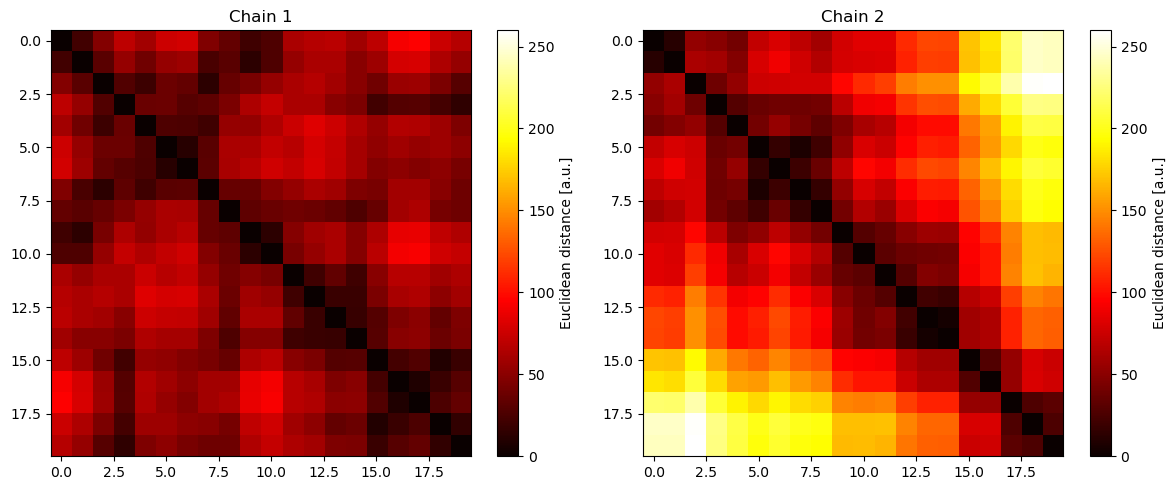

In [31]:
compare_distance_maps(template_chain_list[0], template_chain_list[1])

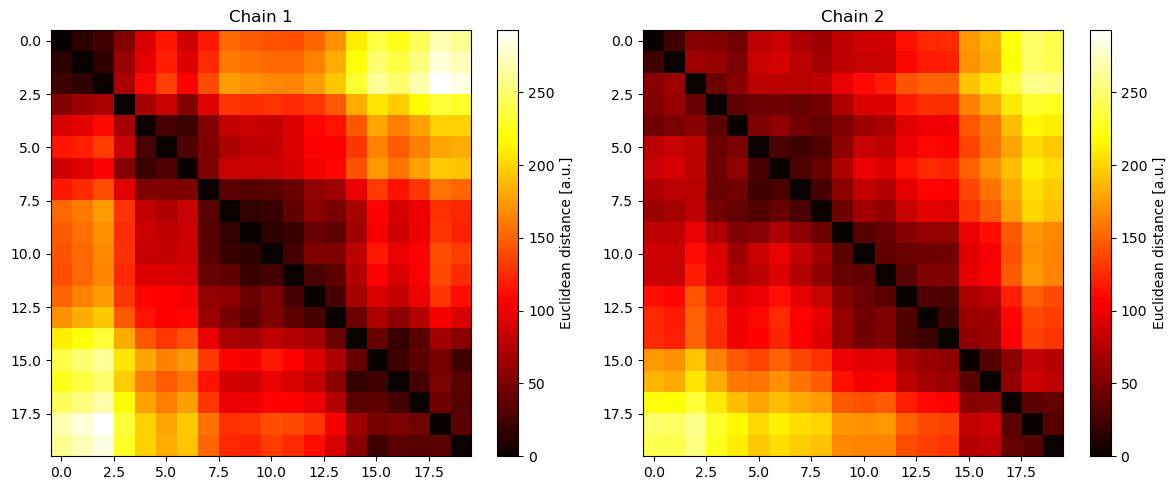

In [28]:
compare_distance_maps(init_model[0], sol[0], type1='flatten_distance_map', type2='flatten_distance_map')

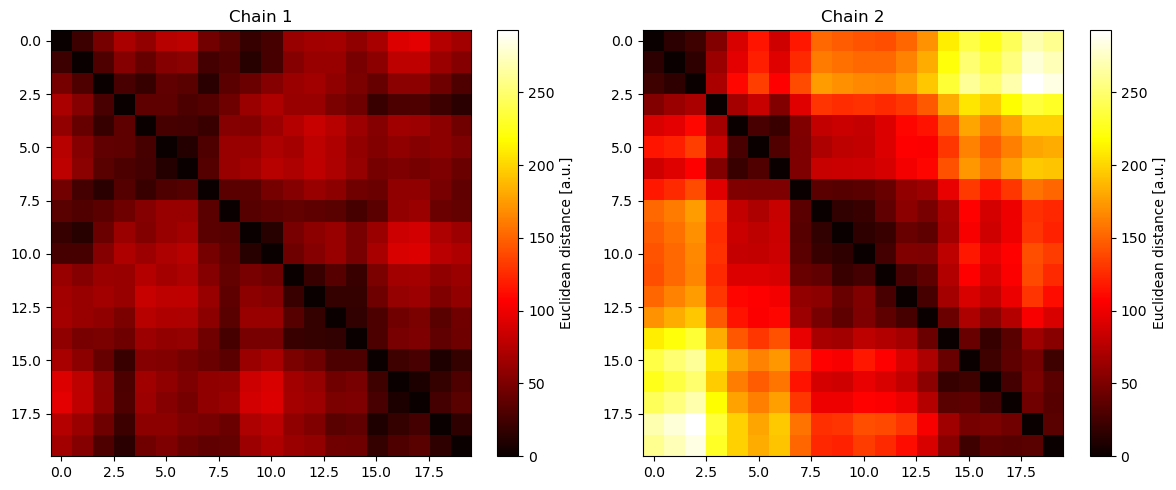

In [27]:
compare_distance_maps(template_chain_list[0], sol[0], type1='polymer', type2='flatten_distance_map')

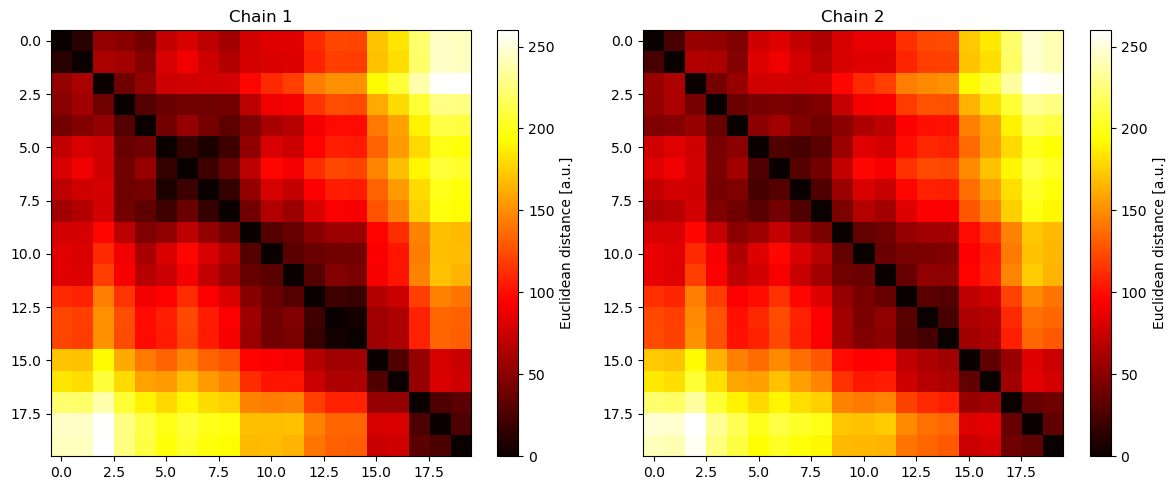

In [14]:
compare_distance_maps(template_chain_list[1], sol[0], type1='polymer', type2='flatten_distance_map')

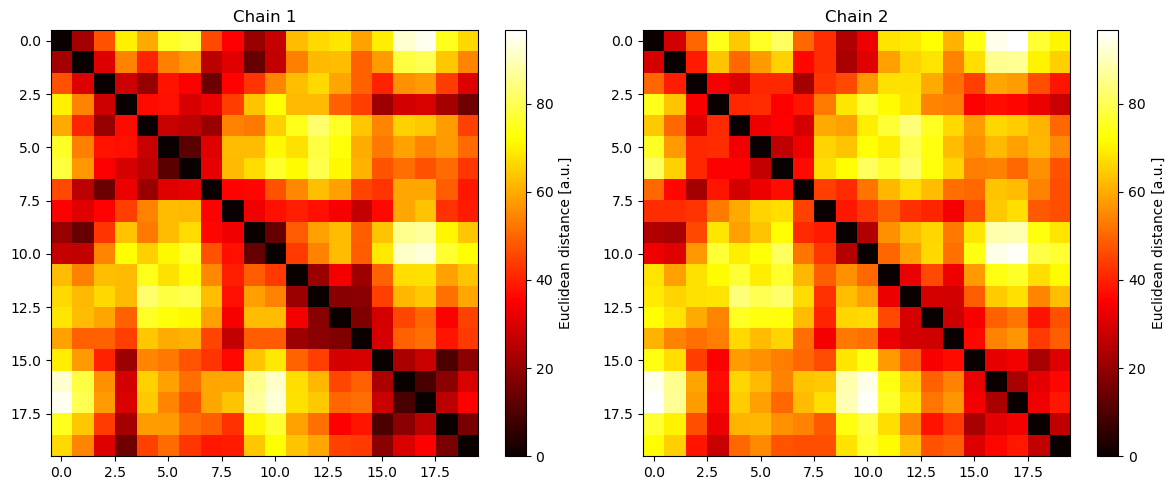

In [16]:
compare_distance_maps(template_chain_list[0], sol[1], type1='polymer', type2='flatten_distance_map')

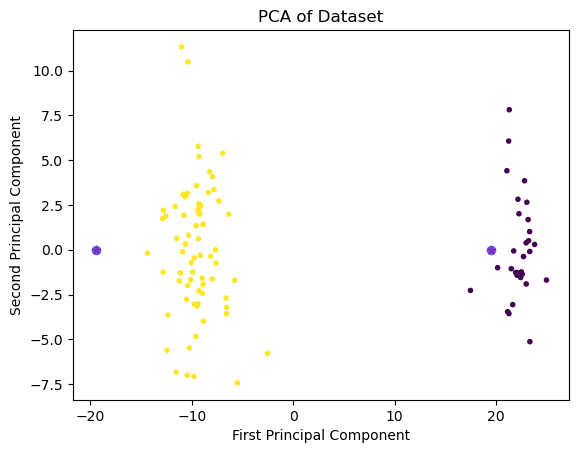

In [43]:
# Use PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualize PCA of original structures 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(observations_flatten)

# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)

init_scaler = StandardScaler()
init_scaled = init_scaler.fit_transform(init_model)
init_pca = pca.fit_transform(init_scaled)

sol_scaler = StandardScaler()
sol_scaled = sol_scaler.fit_transform(sol)
sol_pca = pca.fit_transform(sol_scaled)

# Visualize results
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', c=observation_class_list)
plt.scatter(init_pca[:, 0], init_pca[:, 1], marker='*', color='red', alpha=0.5)
plt.scatter(sol_pca[:, 0], sol_pca[:, 1], marker='o', color='blue', alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.show()


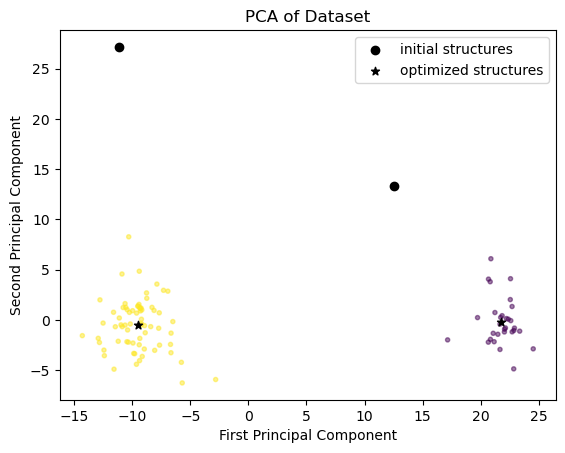

In [50]:
# Use PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualize PCA of original structures 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(np.concatenate([observations_flatten, init_model, sol]))

# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)


# Visualize results
plt.scatter(X_pca[:100, 0], X_pca[:100, 1], marker='.', c=observation_class_list, alpha=0.5)
plt.scatter(X_pca[100:102, 0], X_pca[100:102, 1], marker='o', c='black', label='initial structures')
plt.scatter(X_pca[102:104, 0], X_pca[102:104, 1], marker='*', c='black', label='optimized structures')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.legend()
plt.show()


In [18]:
reducer.fit(observations_flatten)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

Text(0.5, 1.0, 'UMAP projection of distance maps')

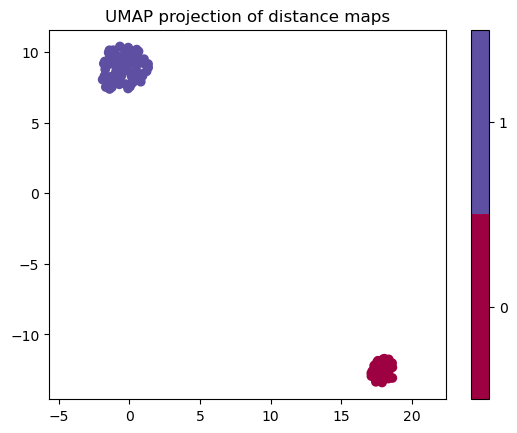

In [19]:
embedding = reducer.transform(observations_flatten)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=observation_class_list, 
    cmap='Spectral')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of distance maps')

In [20]:
template_fit = reducer.transform(jnp.array(sol))

Text(0.5, 1.0, 'UMAP projection of distance maps')

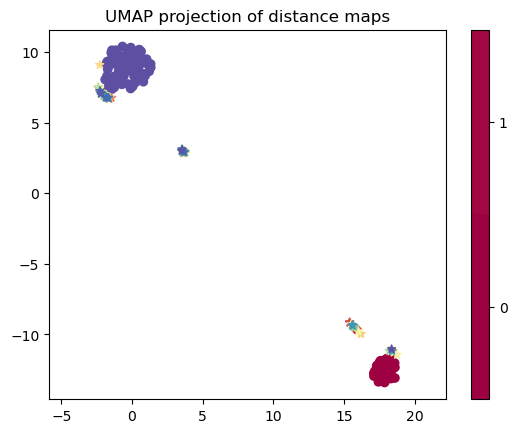

In [21]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=observation_class_list, 
    cmap='Spectral')
plt.scatter(
    template_fit[:, 0],
    template_fit[:, 1],
    c=[x for x in range(len(template_fit))],
    marker='*',
    cmap='Spectral'
    )
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of distance maps')

In [22]:
torch.cuda.empty_cache()

In [52]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_non_negative

init_model = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for m in range(100)]
init_model = [generate_flatten_distance_map(m) for m in init_model]
sol_list = []
torch.cuda.empty_cache()
for i in tqdm(range(1,100)):
    pg = ProjectedGradient(fun=structure_neg_objective_parallelize, projection=projection_non_negative, implicit_diff=True, verbose=True)
    pg_sol = pg.run(init_model[:i])
    sol_list.append(pg_sol.params)
    torch.cuda.empty_cache()

  0%|          | 0/99 [00:00<?, ?it/s]

INFO: jaxopt.ProximalGradient: Iter: 1 Distance btw Iterates (stop. crit.): 378.8677978515625 Stepsize:1.0 
INFO: jaxopt.ProximalGradient: Iter: 2 Distance btw Iterates (stop. crit.): 189.40521240234375 Stepsize:1.0 
INFO: jaxopt.ProximalGradient: Iter: 3 Distance btw Iterates (stop. crit.): 121.37474822998047 Stepsize:1.0 
INFO: jaxopt.ProximalGradient: Iter: 4 Distance btw Iterates (stop. crit.): 34.00090026855469 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 5 Distance btw Iterates (stop. crit.): 18.0554256439209 Stepsize:1.0 
INFO: jaxopt.ProximalGradient: Iter: 6 Distance btw Iterates (stop. crit.): 3.6231727600097656 Stepsize:1.0 
INFO: jaxopt.ProximalGradient: Iter: 7 Distance btw Iterates (stop. crit.): 8.392303466796875 Stepsize:1.0 
INFO: jaxopt.ProximalGradient: Iter: 8 Distance btw Iterates (stop. crit.): 5.905763626098633 Stepsize:1.0 
INFO: jaxopt.ProximalGradient: Iter: 9 Distance btw Iterates (stop. crit.): 0.06775052845478058 Stepsize:2.0 
INFO: jaxopt.ProximalGra

In [53]:
posterior_list = []
for m in tqdm(sol_list):
    posterior_list.append(structure_neg_objective_parallelize(m))

  0%|          | 0/99 [00:00<?, ?it/s]

In [54]:
posterior_list = -np.array(posterior_list)
posterior_list_norm = posterior_list / np.arange(1, len(posterior_list)+1)

Text(0.5, 0, 'Number of models')

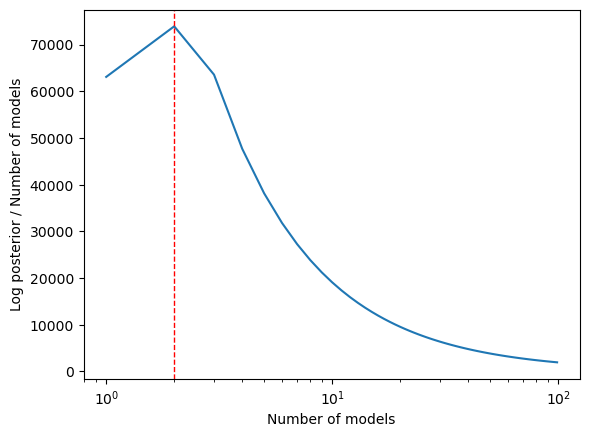

In [55]:
plt.semilogx(np.arange(1, len(posterior_list)+1), posterior_list_norm)
plt.axvline(x=2, color='r', linestyle='--', linewidth=1)
plt.ylabel('Log posterior / Number of models')
plt.xlabel('Number of models')

In [1]:
compare_distance_maps(template_chain_list[1], sol_list[0], type1='polymer', type2='flatten_distance_map')

NameError: name 'compare_distance_maps' is not defined

In [34]:
num_model = 2

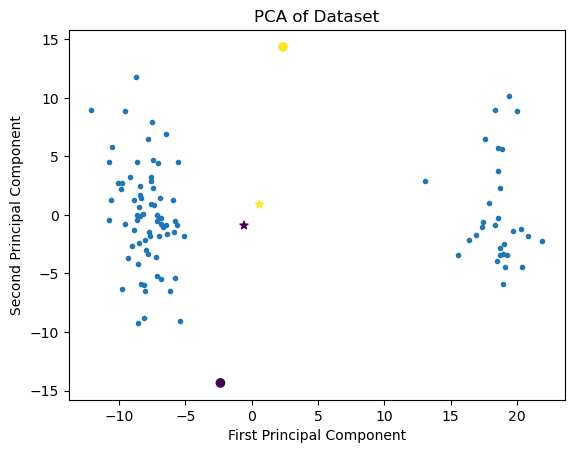

In [47]:
# Use PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visualize PCA of original structures 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(observations_flatten)

# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)

init_scaler = StandardScaler()
init_scaled = init_scaler.fit_transform(init_model[:num_model])
init_pca = pca.transform(init_scaled)

sol_scaler = StandardScaler()
sol_scaled = sol_scaler.fit_transform(sol_list[num_model-1])
sol_pca = pca.transform(sol_scaled)

# Visualize results
plt.scatter(X_pca[:, 0], X_pca[:, 1], marker='.')
plt.scatter(init_pca[:, 0], init_pca[:, 1], marker='*', c=np.arange(num_model))
plt.scatter(sol_pca[:, 0], sol_pca[:, 1], marker='o', c=np.arange(num_model))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.show()


In [49]:
init_model

[array([523.21403745,   4.9070335 , 134.65026193, 613.0069959 ,
        686.91024439, 745.56289432, 845.64681184, 410.42370832,
         22.09426952, 494.43856473, 110.05680392, 412.56745118,
        235.14130534, 796.11189617, 645.90868699, 596.96552878,
         65.27122966, 228.52193367, 198.63427361, 813.09856827,
        148.75133037, 562.52879102, 195.70994256, 827.11985689,
        375.15201997, 164.84430428, 783.82195483, 327.37206982,
        257.55015055, 344.19639725, 149.26883744, 278.64810808,
        767.90119168, 149.51010667, 177.54808733, 269.12192391,
        805.40318254, 920.33465972, 258.14994007, 842.84259969,
        532.37588826, 933.87489983,  36.08813474,  23.67013213,
        456.64355064, 916.1044147 , 901.43790717, 242.08047305,
        170.8681737 , 936.18074859, 835.20294224, 966.35307354,
        585.34061325, 358.44016302,  96.80429094, 457.46325132,
        850.65355387, 532.76266354, 664.81529057, 697.39840588,
        926.33912009, 684.24491308, 912.